# Steiner Tree - Algoritmo Dreyfus-Wagner (Exacto)

Este notebook implementa el **algoritmo de Dreyfus-Wagner**, que encuentra la solución **ÓPTIMA** al problema del Steiner Tree.

## ¿Qué es el Steiner Tree Problem?

**Problema**: Dado un grafo con algunos nodos marcados como **terminales**, encontrar el árbol de peso mínimo que conecte todos los terminales.

**Diferencia clave con MST tradicional**:
- **MST tradicional**: Conecta **TODOS** los nodos del grafo
- **Steiner Tree**: Solo debe conectar los **terminales**, pero puede usar nodos intermedios opcionales para reducir el peso

**Ejemplo**:
- Grafo con 10 nodos, pero solo 4 son **terminales** (deben conectarse)
- **MST baseline**: Conectar solo los 4 terminales directamente (peso = 20)
- **Steiner Tree óptimo**: Usar 2 nodos intermedios para conectar los terminales (peso = 15)
- **Mejora**: 25% menos peso usando nodos intermedios estratégicamente

## Características del algoritmo:
1. **Algoritmo exacto** - garantiza encontrar la solución óptima
2. **Programación dinámica** - complejidad O(3ⁿ × n²) donde n = número de terminales
3. **Limitación práctica** - funciona bien hasta ~12-15 terminales
4. Comparación con MST (baseline que solo conecta terminales)

## Diferencias con el algoritmo heurístico:
- **Heurístico (Fermat iterativo)**: Rápido, aproximado, O(n⁴)
- **Dreyfus-Wagner**: Lento, exacto, O(3ⁿ × n²)

In [28]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import euclidean
from itertools import combinations, chain
import time

print("Libraries imported successfully!")

Libraries imported successfully!


## Graph Generation Functions

Mismas funciones que en el notebook anterior para generar grafos aleatorios.

In [29]:
def generate_random_points(n_nodes, seed=42):
    """
    Generate random 2D points for graph nodes.
    
    Parameters:
    - n_nodes: Number of nodes to generate
    - seed: Random seed for reproducibility
    
    Returns: Array of (x, y) coordinates
    """
    np.random.seed(seed)
    return np.random.uniform(0, 10, (n_nodes, 2))


def create_complete_graph(points):
    """
    Create a complete graph from points with Euclidean distances as weights.
    
    Parameters:
    - points: Array of 2D coordinates
    
    Returns: NetworkX graph with all edges weighted by distance
    """
    n = len(points)
    G = nx.Graph()
    
    # Add nodes with position attributes
    for i in range(n):
        G.add_node(i, pos=points[i])
    
    # Add edges with weights (Euclidean distances)
    for i, j in combinations(range(n), 2):
        distance = euclidean(points[i], points[j])
        G.add_edge(i, j, weight=distance)
    
    return G

print("Graph generation functions defined!")

Graph generation functions defined!


## MST Implementation (Referencia)

Para comparar con la solución óptima de Dreyfus-Wagner.

In [30]:
def compute_mst(G):
    """
    Compute Minimum Spanning Tree.
    
    Parameters:
    - G: Input graph with weighted edges
    
    Returns: (MST graph, total weight)
    """
    mst = nx.minimum_spanning_tree(G, weight='weight')
    total_weight = sum(G[u][v]['weight'] for u, v in mst.edges())
    return mst, total_weight


def compute_mst_terminals(G, terminals):
    """
    Compute MST connecting only terminal nodes via shortest paths.
    
    This is the CORRECT baseline for comparing with Steiner Tree:
    1. Build abstract graph with shortest path distances between terminals
    2. Compute MST structure on abstract graph
    3. Expand each MST edge to actual shortest path in original graph
    4. Sum REAL edge weights from original graph
    
    Parameters:
    - G: Complete graph with all nodes and weighted edges
    - terminals: List of terminal nodes that must be connected
    
    Returns: (MST graph with intermediate nodes, total weight using real edges)
    """
    # Step 1: Build abstract graph with shortest path distances
    terminal_graph = nx.Graph()
    for t in terminals:
        terminal_graph.add_node(t, pos=G.nodes[t]['pos'])
    for i, t1 in enumerate(terminals):
        for t2 in terminals[i+1:]:
            path_length = nx.shortest_path_length(G, t1, t2, weight='weight')
            terminal_graph.add_edge(t1, t2, weight=path_length)
    
    # Step 2: Get MST structure (which terminals connect to which)
    mst_structure = nx.minimum_spanning_tree(terminal_graph, weight='weight')
    
    # Step 3: Build ACTUAL MST with intermediate nodes
    mst_terminals = nx.Graph()
    for node in G.nodes():
        mst_terminals.add_node(node, pos=G.nodes[node]['pos'])
    
    # Step 4: Expand each MST edge to shortest path in original graph
    for t1, t2 in mst_structure.edges():
        path = nx.shortest_path(G, t1, t2, weight='weight')
        for i in range(len(path) - 1):
            n1, n2 = path[i], path[i+1]
            if not mst_terminals.has_edge(n1, n2):
                mst_terminals.add_edge(n1, n2, weight=G[n1][n2]['weight'])
    
    # Step 5: Clean up unused nodes
    used_nodes = set()
    for u, v in mst_terminals.edges():
        used_nodes.add(u)
        used_nodes.add(v)
    unused = [n for n in mst_terminals.nodes() if n not in used_nodes]
    mst_terminals.remove_nodes_from(unused)
    
    # Step 6: Calculate actual weight from REAL edges
    mst_terminals_weight = sum(mst_terminals[u][v]['weight'] for u, v in mst_terminals.edges())
    
    return mst_terminals, mst_terminals_weight

print("MST functions defined!")
print("✓ compute_mst_terminals() correctly calculates weight from REAL edges")

MST functions defined!
✓ compute_mst_terminals() correctly calculates weight from REAL edges


## Algoritmo Dreyfus-Wagner (Exacto)

### Cómo funciona:

El algoritmo usa **programación dinámica** en dos fases:

**Fase 1: DP sobre subconjuntos de terminales**
- Para cada nodo `v` y cada subconjunto de terminales `S`:
- `dp[v][S]` = peso mínimo del árbol que conecta `S` y está enraizado en `v`
- Fórmula: `dp[v][S] = min(dp[v][S1] + dp[v][S2])` para todas las particiones S1, S2 de S

**Fase 2: Expansión entre nodos**
- Usa shortest paths para expandir soluciones entre diferentes nodos

**Complejidad**: O(3ⁿ × n²) donde n = número de terminales
- 3ⁿ: número de subconjuntos que se deben considerar (cada elemento puede estar en S1, S2, o ninguno)
- n²: para cada par de nodos

**Limitación**: Práctico solo para n ≤ 12-15 terminales

In [31]:
def dreyfus_wagner(G, terminals):
    """
    Implementación del algoritmo Dreyfus-Wagner para Steiner Tree.
    
    Encuentra la solución ÓPTIMA usando programación dinámica.
    
    Parameters:
    - G: Grafo completo con pesos en las aristas
    - terminals: Lista de nodos terminales que deben ser conectados
    
    Returns: (Steiner tree, peso total, tiempo de ejecución)
    
    Complejidad: O(3^n * n^2) donde n = |terminals|
    """
    start_time = time.time()
    
    if len(terminals) < 2:
        raise ValueError("Need at least 2 terminal nodes")
    
    n = G.number_of_nodes()
    terminals_set = set(terminals)
    k = len(terminals)
    
    # Precalcular shortest paths entre todos los pares de nodos (distancias y caminos)
    dist = {}
    paths = {}
    for source in G.nodes():
        dist[source], paths[source] = nx.single_source_dijkstra(G, source, weight='weight')
    
    # dp[v][S] = costo mínimo del árbol Steiner que conecta el subconjunto S ⊆ terminals
    #            y está enraizado en el nodo v
    dp = [{} for _ in range(n)]
    parent = [{} for _ in range(n)]  # Para reconstruir el árbol
    
    # Mapeo de terminales a índices para usar en bitmasks
    term_list = sorted(terminals)
    term_to_idx = {t: i for i, t in enumerate(term_list)}
    
    # Inicialización: subconjuntos de tamaño 1
    for v in range(n):
        for t in terminals:
            subset = 1 << term_to_idx[t]  # Bitmask con solo el terminal t
            if v == t:
                dp[v][subset] = 0
                parent[v][subset] = ('terminal', t)
            else:
                dp[v][subset] = dist[v][t]
                parent[v][subset] = ('path', t)
    
    # Iterar sobre todos los subconjuntos de terminales (de tamaño 2 a k)
    for subset_size in range(2, k + 1):
        # Generar todos los subconjuntos de tamaño subset_size
        for subset_terminals in combinations(term_list, subset_size):
            # Convertir a bitmask
            subset = 0
            for t in subset_terminals:
                subset |= (1 << term_to_idx[t])
            
            # FASE 1: Para cada nodo v, calcular ramificaciones (combinaciones de subárboles)
            for v in range(n):
                min_cost = float('inf')
                best_partition = None
                
                # Iterar sobre todas las particiones no triviales de subset
                subset1 = subset
                while subset1 > 0:
                    subset1 = (subset1 - 1) & subset
                    if subset1 == 0:
                        break
                    
                    subset2 = subset ^ subset1
                    
                    if subset1 in dp[v] and subset2 in dp[v]:
                        cost = dp[v][subset1] + dp[v][subset2]
                        if cost < min_cost:
                            min_cost = cost
                            best_partition = (subset1, subset2)
                
                dp[v][subset] = min_cost
                if best_partition:
                    parent[v][subset] = ('branch', best_partition[0], best_partition[1])
            
            # FASE 2: Expandir soluciones entre diferentes nodos usando shortest paths
            # Este paso debe estar DESPUÉS de calcular todas las ramificaciones
            for v in range(n):
                for u in range(n):
                    if u != v and subset in dp[u]:
                        cost = dp[u][subset] + dist[u][v]
                        if cost < dp[v][subset]:
                            dp[v][subset] = cost
                            parent[v][subset] = ('extend', u, subset)
    
    # Encontrar el nodo raíz óptimo para el conjunto completo de terminales
    full_subset = (1 << k) - 1  # Todos los terminales
    min_cost = float('inf')
    best_root = None
    
    for v in range(n):
        if full_subset in dp[v] and dp[v][full_subset] < min_cost:
            min_cost = dp[v][full_subset]
            best_root = v
    
    # Reconstruir el árbol usando los caminos calculados
    steiner_tree = nx.Graph()
    for node in G.nodes():
        steiner_tree.add_node(node, pos=G.nodes[node]['pos'])
    
    def add_path_edges(u, v):
        """Agregar todas las aristas del camino más corto entre u y v"""
        if u == v:
            return
        path = paths[u][v]
        for i in range(len(path) - 1):
            n1, n2 = path[i], path[i+1]
            if not steiner_tree.has_edge(n1, n2):
                weight = G[n1][n2]['weight']
                steiner_tree.add_edge(n1, n2, weight=weight)
    
    def reconstruct(v, subset):
        """Reconstruir árbol recursivamente desde la tabla DP"""
        if subset not in parent[v]:
            return
        
        p = parent[v][subset]
        
        if p[0] == 'terminal':
            # Caso base: v es un terminal
            return
        elif p[0] == 'path':
            # Caso base: conectar v a un terminal t
            t = p[1]
            add_path_edges(v, t)
        elif p[0] == 'branch':
            # v es un nodo de ramificación
            subset1, subset2 = p[1], p[2]
            reconstruct(v, subset1)
            reconstruct(v, subset2)
        elif p[0] == 'extend':
            # Extender desde otro nodo u
            u, sub = p[1], p[2]
            add_path_edges(u, v)
            reconstruct(u, sub)
    
    reconstruct(best_root, full_subset)
    
    # Limpiar nodos no usados
    used_nodes = set()
    for u, v in steiner_tree.edges():
        used_nodes.add(u)
        used_nodes.add(v)
    
    unused = [n for n in steiner_tree.nodes() if n not in used_nodes]
    steiner_tree.remove_nodes_from(unused)
    
    elapsed_time = time.time() - start_time
    
    return steiner_tree, min_cost, elapsed_time

print("Dreyfus-Wagner algorithm defined!")
print("⚠️ Warning: This algorithm is EXACT but SLOW - use only with ≤12 terminals!")

Dreyfus-Wagner algorithm defined!
⚠️ Warning: This algorithm is EXACT but SLOW - use only with ≤12 terminals!


## Visualization Functions

In [32]:
def plot_tree(tree, title, terminals=None, all_nodes_graph=None, ax=None):
    """
    Plot a tree with nodes, edges, and labels.
    
    Parameters:
    - tree: NetworkX graph to plot (the solution tree)
    - title: Title for the plot
    - terminals: List of terminal nodes to highlight in red
    - all_nodes_graph: Complete graph with ALL nodes (to show unused nodes in gray)
    - ax: Matplotlib axis (optional)
    """
    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
    
    # Use all_nodes_graph if provided, otherwise just the tree
    graph_to_show = all_nodes_graph if all_nodes_graph is not None else tree
    
    # Get positions from the graph
    pos = nx.get_node_attributes(graph_to_show, 'pos')
    
    # Determine node colors and labels
    node_colors = []
    node_sizes = []
    alphas = []
    
    for node in graph_to_show.nodes():
        if node in tree.nodes():
            # Node is in the solution
            node_sizes.append(700)
            alphas.append(0.9)
            if terminals is not None and node in terminals:
                node_colors.append('red')     # Terminals in red
            else:
                node_colors.append('green')   # Steiner nodes in green
        else:
            # Node is NOT in the solution (unused)
            node_colors.append('lightgray')
            node_sizes.append(500)
            alphas.append(0.3)
    
    # Draw all nodes
    for i, node in enumerate(graph_to_show.nodes()):
        nx.draw_networkx_nodes(graph_to_show, pos, nodelist=[node],
                             node_color=[node_colors[i]], 
                             node_size=node_sizes[i], 
                             alpha=alphas[i], ax=ax)
    
    # Draw only edges that are in the solution tree
    nx.draw_networkx_edges(tree, pos, width=3, alpha=0.6, ax=ax)
    
    # Draw labels for all nodes
    nx.draw_networkx_labels(graph_to_show, pos, font_size=14, font_weight='bold', ax=ax)
    
    # Draw edge weights only for edges in the solution
    edge_labels = nx.get_edge_attributes(tree, 'weight')
    edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(tree, pos, edge_labels, font_size=10, ax=ax)
    
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')


def plot_original_graph(G, terminals, ax=None):
    """
    Plot the original graph showing all nodes and edges.
    
    Parameters:
    - G: Original complete graph
    - terminals: List of terminal nodes
    - ax: Matplotlib axis to plot on
    """
    if ax is None:
        plt.figure(figsize=(10, 8))
        ax = plt.gca()
    
    pos = nx.get_node_attributes(G, 'pos')
    
    node_colors = []
    for node in G.nodes():
        if node in terminals:
            node_colors.append('red')      # Terminal nodes
        else:
            node_colors.append('lightblue') # Non-terminal nodes
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=700, alpha=0.9, ax=ax)
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.3, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold', ax=ax)
    
    # Only show edge weights for small graphs
    if len(G.edges()) <= 30:
        edge_labels = nx.get_edge_attributes(G, 'weight')
        edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8, alpha=0.5, ax=ax)
    
    ax.set_title(f'Original Graph\n{len(G.nodes())} nodes, {len(G.edges())} edges\nRed = Terminals | Blue = Non-terminals', 
                fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')


def plot_comparison(mst_full, mst_terminals, steiner_tree, mst_full_weight, mst_terminals_weight, steiner_weight, terminals=None, original_graph=None):
    """
    Plot 2x2 grid: Original Graph, MST Full, MST Terminals, Steiner Tree.
    
    Parameters:
    - mst_full: MST connecting ALL nodes (traditional MST)
    - mst_terminals: MST connecting only terminals (baseline for Steiner)
    - steiner_tree: Steiner Tree (optimal from Dreyfus-Wagner)
    - mst_full_weight: Total weight of MST (all nodes)
    - mst_terminals_weight: Total weight of MST (terminals only)
    - steiner_weight: Total weight of Steiner Tree
    - terminals: Terminal nodes to highlight
    - original_graph: Complete graph with ALL nodes
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 16))
    
    # Plot 1: Original Graph (top-left)
    if original_graph is not None:
        plot_original_graph(original_graph, terminals, ax1)
    
    # Plot 2: MST Full - Traditional MST connecting ALL nodes (top-right)
    # Don't distinguish terminals here - all nodes are in the solution
    plot_tree(mst_full, f'MST (ALL Nodes - Traditional)\nTotal Weight: {mst_full_weight:.2f}\nConnects all {len(original_graph.nodes())} nodes', 
             None, original_graph, ax2)
    
    # Plot 3: MST Terminals - MST connecting only terminals (bottom-left)
    plot_tree(mst_terminals, f'MST (Terminals Only - Baseline)\nTotal Weight: {mst_terminals_weight:.2f}\nConnects only {len(terminals)} terminals', 
             terminals, original_graph, ax3)
    
    # Plot 4: Steiner Tree - Optimal solution (bottom-right)
    improvement = ((mst_terminals_weight - steiner_weight) / mst_terminals_weight) * 100
    
    # Check if Dreyfus-Wagner actually improved (it should ALWAYS improve or equal)
    # Use tolerance for floating point comparison
    if steiner_weight > mst_terminals_weight + 1e-9:  # Tolerance for floating point errors
        title = f'Steiner Tree (Dreyfus-Wagner)\nTotal Weight: {steiner_weight:.2f}\n⚠️ WARNING: Algorithm bug detected - MST-Terminals is better!'
    else:
        title = f'Steiner Tree (OPTIMAL - Dreyfus-Wagner)\nTotal Weight: {steiner_weight:.2f}\nImprovement vs MST-Terminals: {improvement:.1f}%'
    
    plot_tree(steiner_tree, title, terminals, original_graph, ax4)
    
    plt.tight_layout()
    
    # Add separating lines between subplots (after tight_layout)
    # Vertical line (center)
    fig.add_artist(plt.Line2D([0.5, 0.5], [0.05, 0.95], color='black', linewidth=3, transform=fig.transFigure, zorder=1000))
    # Horizontal line (center)
    fig.add_artist(plt.Line2D([0.05, 0.95], [0.5, 0.5], color='black', linewidth=3, transform=fig.transFigure, zorder=1000))
    
    plt.show()

print("Visualization functions defined!")
print("Legend: Red = Terminals | Green = Steiner nodes | Gray = Unused nodes")

Visualization functions defined!
Legend: Red = Terminals | Green = Steiner nodes | Gray = Unused nodes


## Custom Example

Total nodes in graph: 6
TERMINALS (must connect): [0, 2, 4]
Optional Steiner nodes: [1, 3, 5]



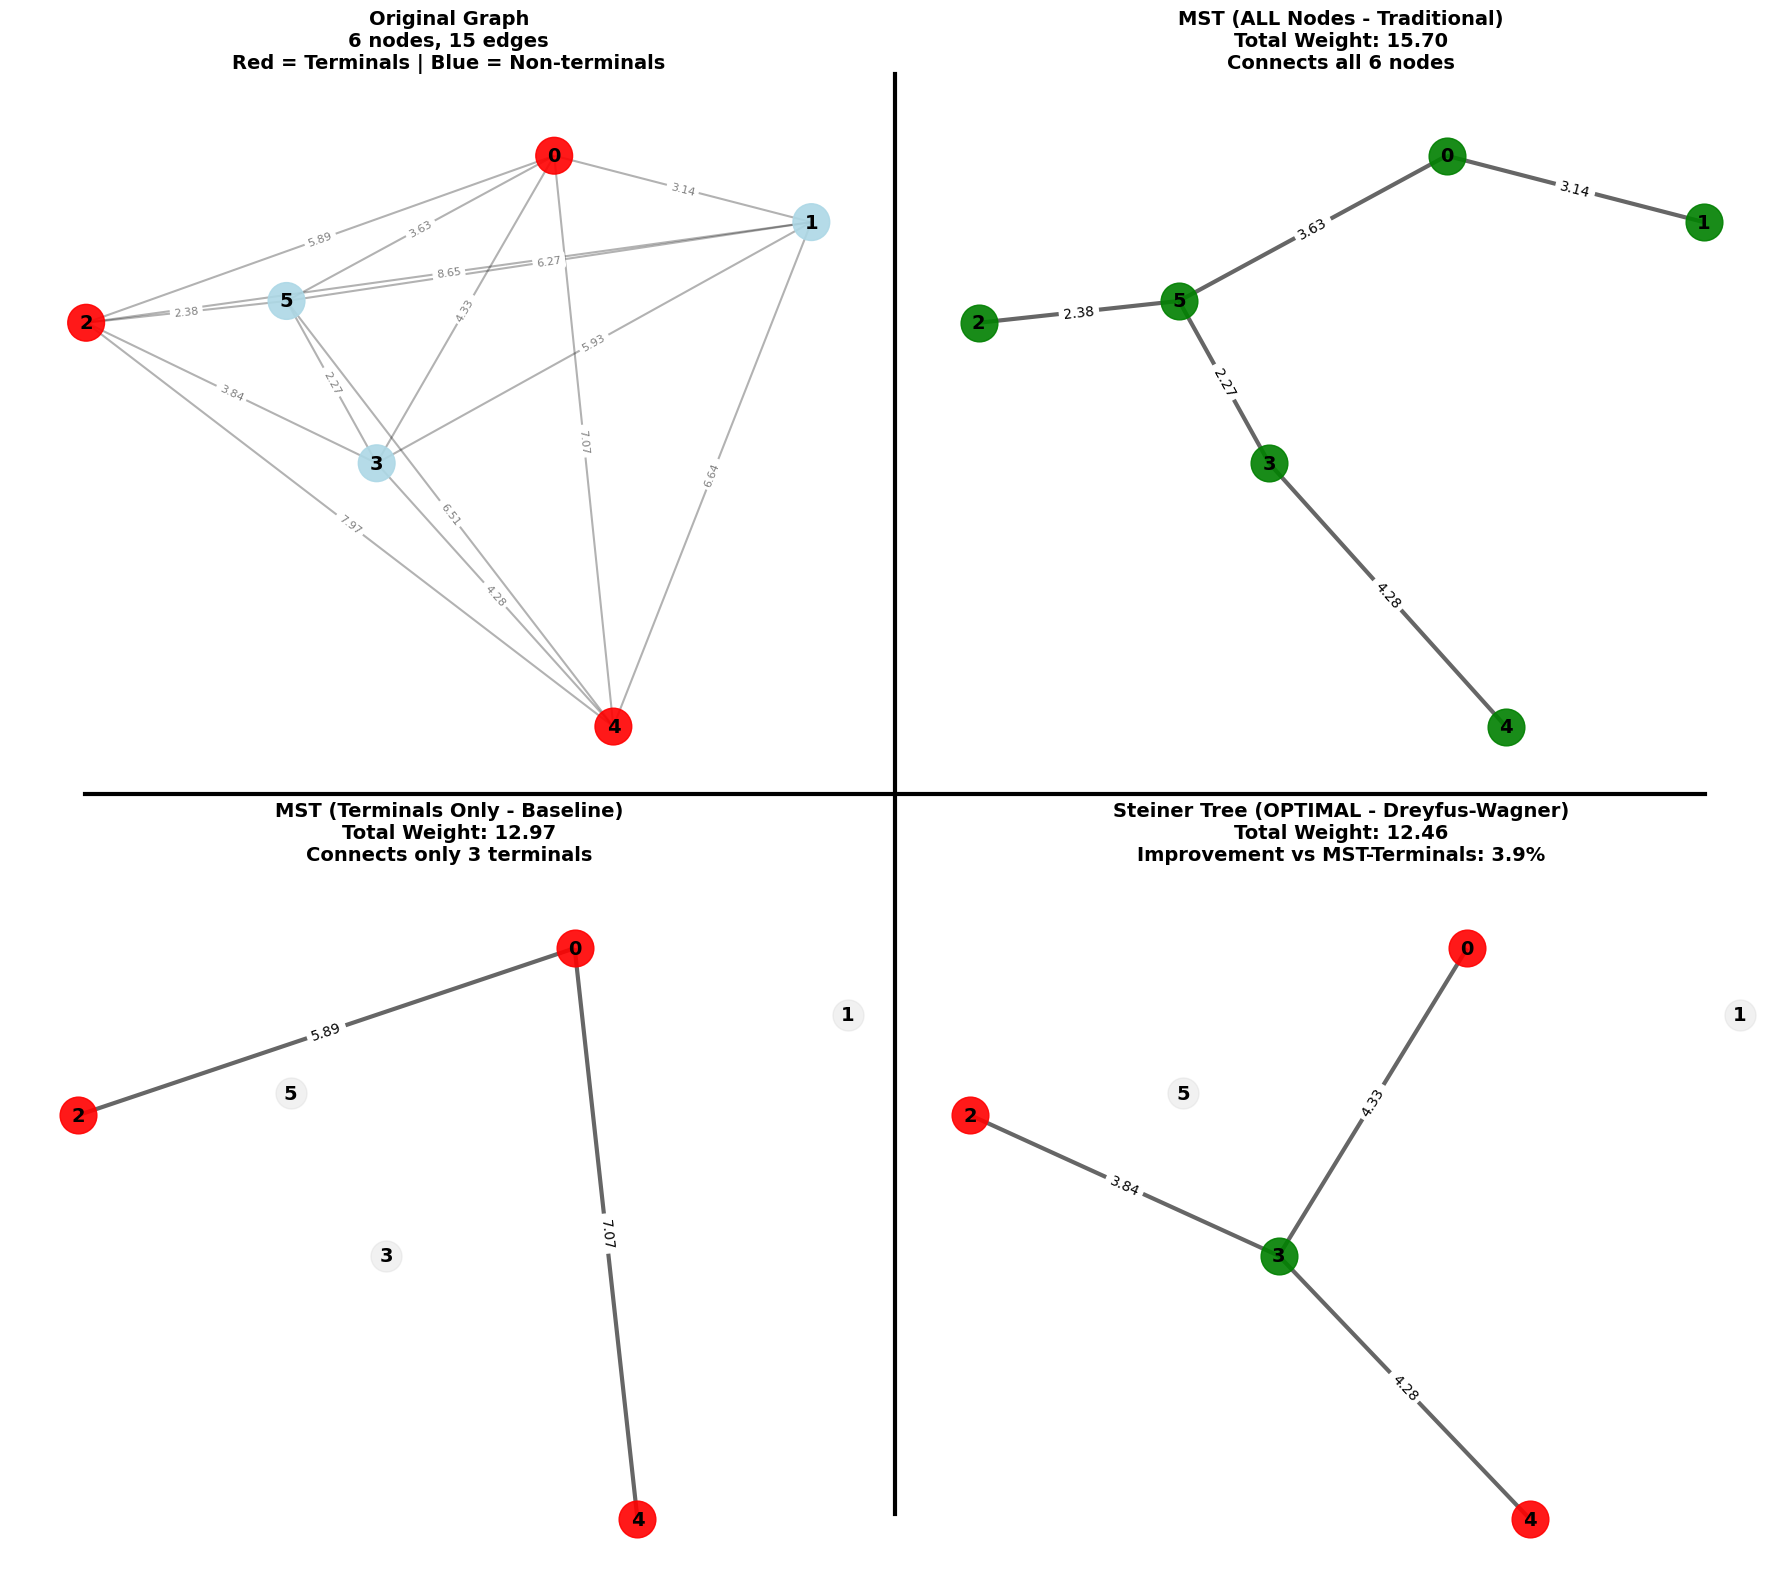

In [33]:
# Generate points
total_nodes = 6
points_custom = generate_random_points(n_nodes=total_nodes, seed=20)
G_Custom = create_complete_graph(points_custom)
terminals_custom = [0, 2, 4]

print(f"Total nodes in graph: {len(points_custom)}")
print(f"TERMINALS (must connect): {terminals_custom}")
print(f"Optional Steiner nodes: {[i for i in range(total_nodes) if i not in terminals_custom]}")
print()

mst_full_custom, mst_full_weight_custom = compute_mst(G_Custom)
mst_terminals_custom, mst_terminals_weight_custom = compute_mst_terminals(G_Custom, terminals_custom)
steiner_custom, steiner_weight_custom, exec_time_custom = dreyfus_wagner(G_Custom, terminals_custom)
steiner_nodes_used = [n for n in steiner_custom.nodes() if n not in terminals_custom]

# Plot comparison - 2x2 grid
plot_comparison(mst_full_custom, mst_terminals_custom, steiner_custom, mst_full_weight_custom, mst_terminals_weight_custom, steiner_weight_custom, terminals_custom, G_Custom)

## Example 1: 8 Nodes (4 Terminales, 4 Steiner disponibles)

Total nodes in graph: 8
TERMINALS (must connect): [0, 2, 5, 7]
Optional Steiner nodes: [1, 3, 4, 6]



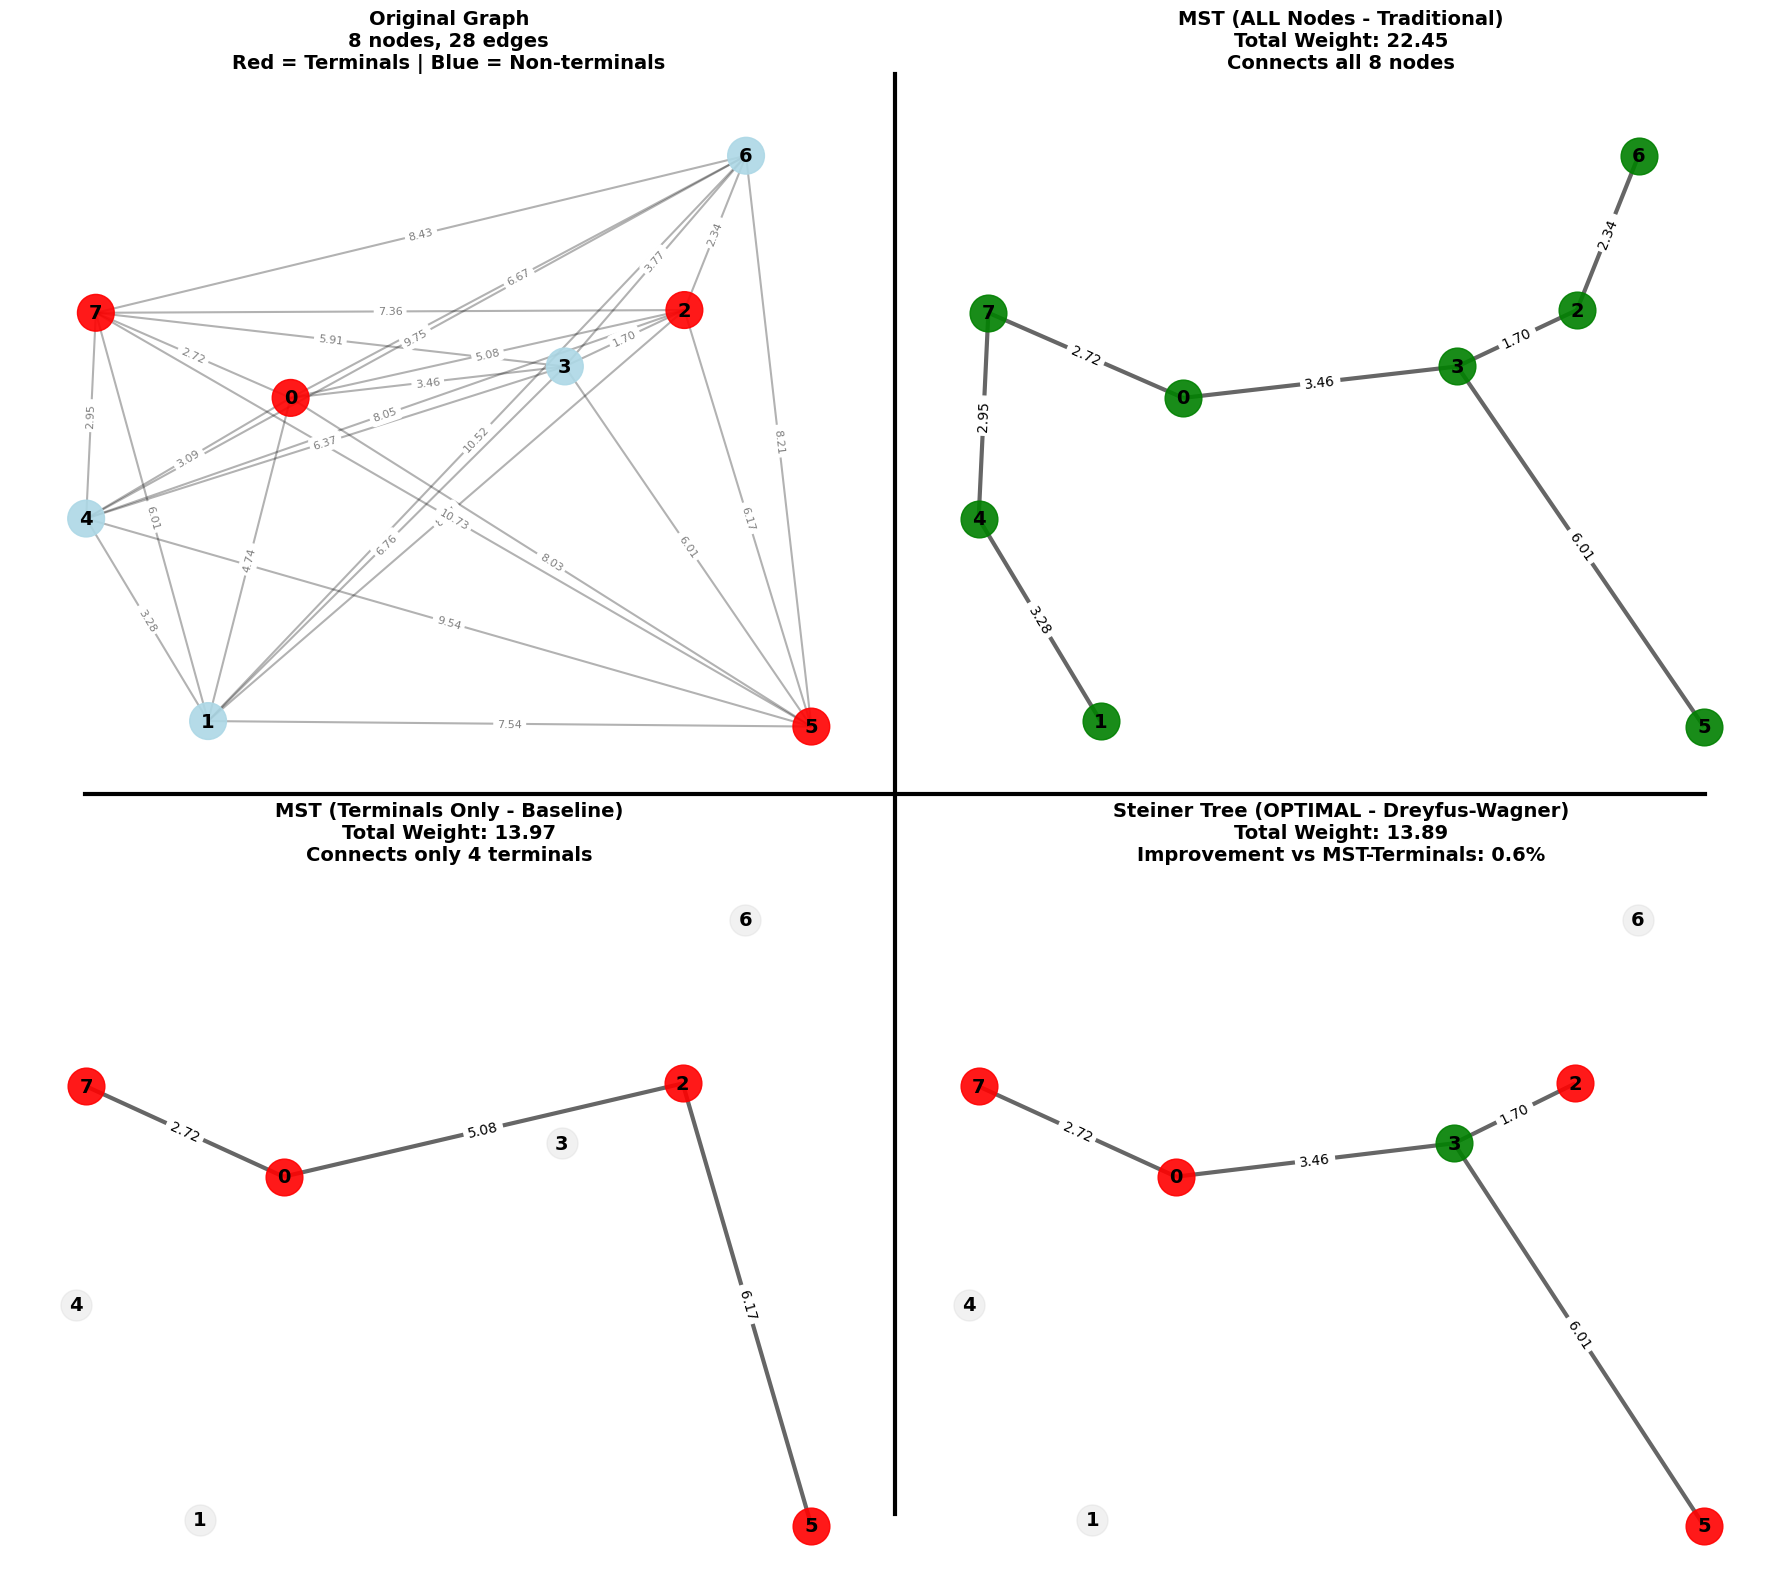

In [34]:
# Generate points
total_nodes = 8
points_8 = generate_random_points(n_nodes=total_nodes, seed=17)
G_8 = create_complete_graph(points_8)
terminals_8 = [0, 2, 5, 7]  # Solo estos 4 deben conectarse

print(f"Total nodes in graph: {len(points_8)}")
print(f"TERMINALS (must connect): {terminals_8}")
print(f"Optional Steiner nodes: {[i for i in range(total_nodes) if i not in terminals_8]}")
print()

# MST tradicional (todos los nodos)
mst_full_8, mst_full_weight_8 = compute_mst(G_8)
mst_terminals_8, mst_terminals_weight_8 = compute_mst_terminals(G_8, terminals_8)
steiner_8, steiner_weight_8, exec_time_8 = dreyfus_wagner(G_8, terminals_8)

# Plot comparison - 2x2 grid
plot_comparison(mst_full_8, mst_terminals_8, steiner_8, mst_full_weight_8, mst_terminals_weight_8, steiner_weight_8, terminals_8, G_8)

## Example 2: 10 Nodes (4 Terminales, 6 Steiner disponibles)

Total nodes in graph: 10
Terminal nodes (MUST be in solution): [1, 4, 7, 9]
Available Steiner nodes (optional): [0, 2, 3, 5, 6, 8]


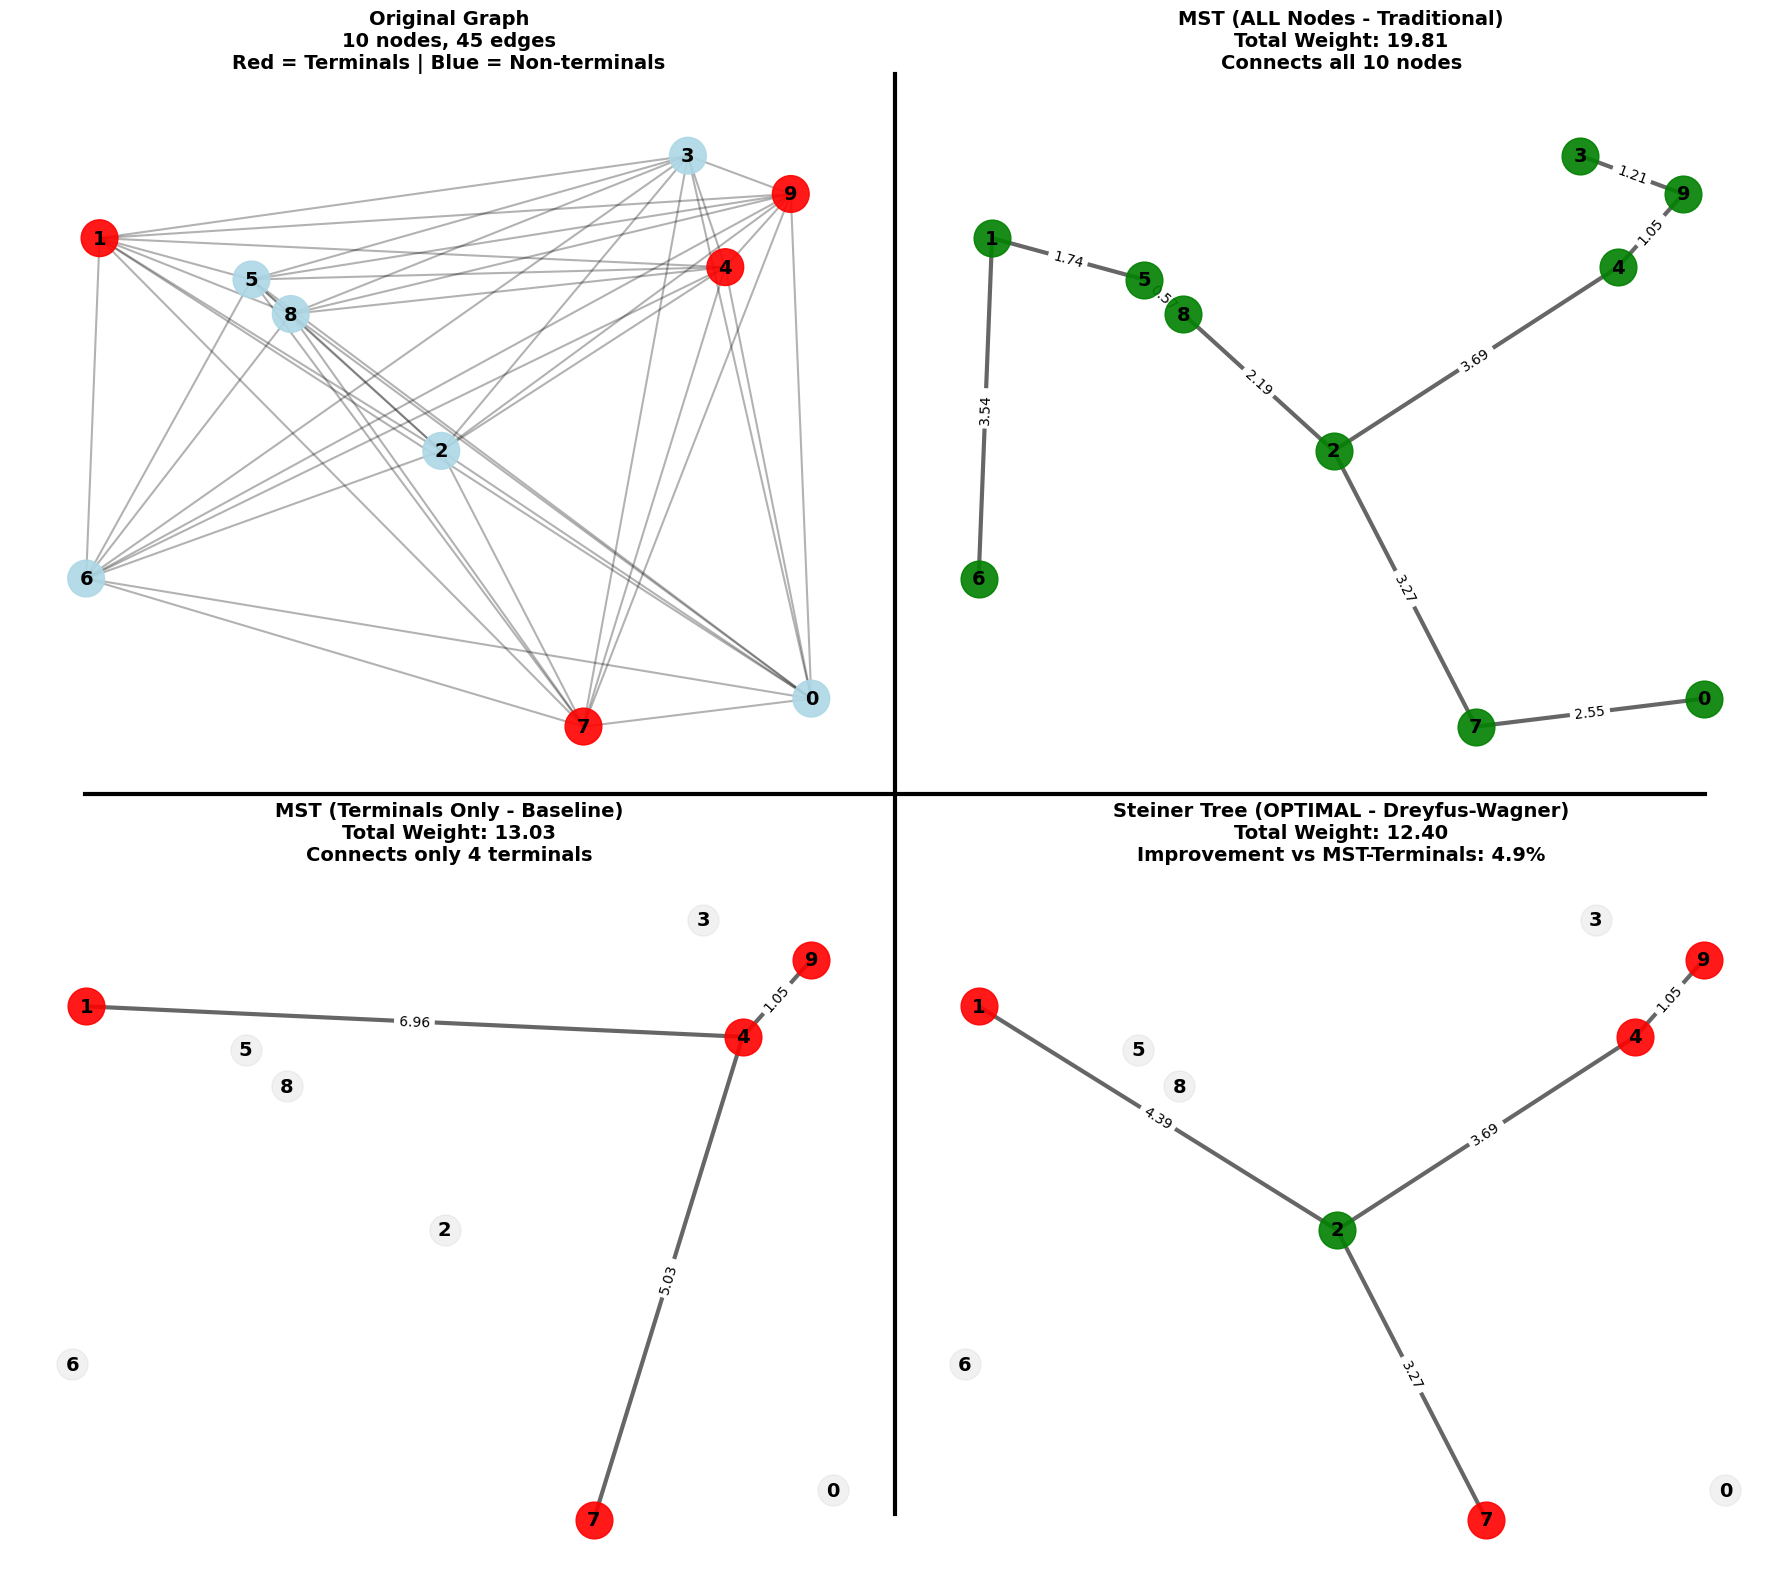

In [35]:
# Generate points
total_nodes = 10
points_10 = generate_random_points(n_nodes=total_nodes, seed=29)
G_10 = create_complete_graph(points_10)
terminals_10 = [1, 4, 7, 9]  # Solo 4 nodos son terminales

print(f"Total nodes in graph: {len(points_10)}")
print(f"Terminal nodes (MUST be in solution): {terminals_10}")
print(f"Available Steiner nodes (optional): {[i for i in range(total_nodes) if i not in terminals_10]}")

# Traditional MST (all nodes)
mst_full_10, mst_full_weight_10 = compute_mst(G_10)
mst_terminals_10, mst_terminals_weight_10 = compute_mst_terminals(G_10, terminals_10)

# Compute OPTIMAL Steiner Tree with Dreyfus-Wagner
steiner_10, steiner_weight_10, exec_time_10 = dreyfus_wagner(G_10, terminals_10)
steiner_nodes_used = [n for n in steiner_10.nodes() if n not in terminals_10]

# Plot comparison - 2x2 grid
plot_comparison(mst_full_10, mst_terminals_10, steiner_10, mst_full_weight_10, mst_terminals_weight_10, steiner_weight_10, terminals_10, G_10)

## Example 3: 12 Nodes (5 Terminales) - Límite Práctico

Total nodes in graph: 12
Terminal nodes: [0, 3, 6, 9, 11]
Available Steiner nodes: [1, 2, 4, 5, 7, 8, 10]


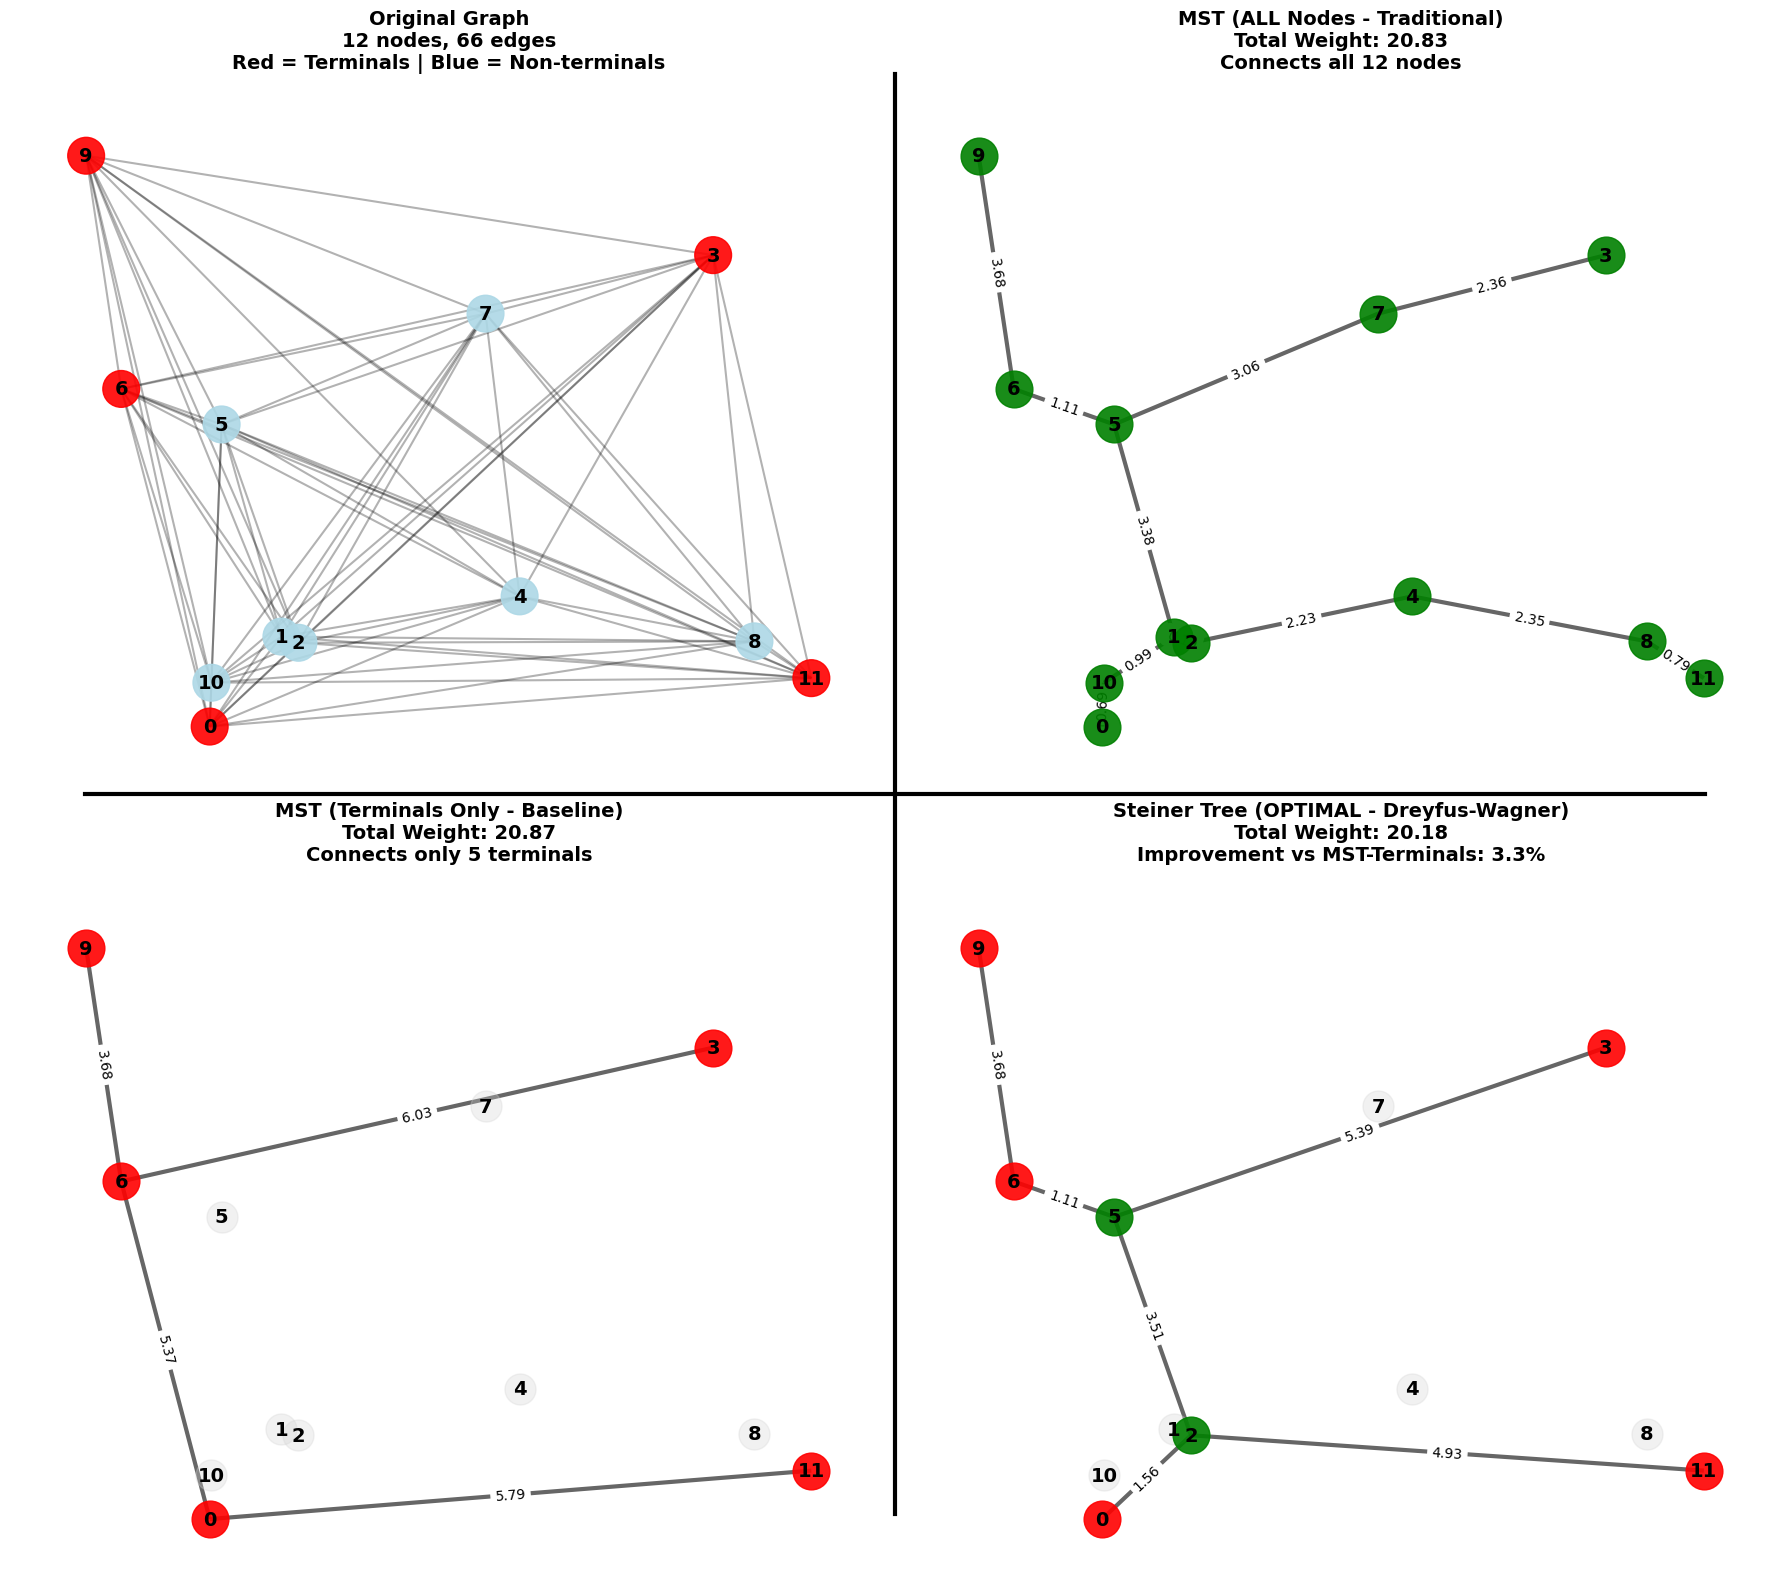

In [36]:
# Generate points
total_nodes = 12
points_12 = generate_random_points(n_nodes=total_nodes, seed=65)
G_12 = create_complete_graph(points_12)
terminals_12 = [0, 3, 6, 9, 11]  # 5 terminales

print(f"Total nodes in graph: {len(points_12)}")
print(f"Terminal nodes: {terminals_12}")
print(f"Available Steiner nodes: {[i for i in range(total_nodes) if i not in terminals_12]}")

# Traditional MST (all nodes)
mst_full_12, mst_full_weight_12 = compute_mst(G_12)
mst_terminals_12, mst_terminals_weight_12 = compute_mst_terminals(G_12, terminals_12)

# Compute OPTIMAL Steiner Tree with Dreyfus-Wagner
steiner_12, steiner_weight_12, exec_time_12 = dreyfus_wagner(G_12, terminals_12)
steiner_nodes_used = [n for n in steiner_12.nodes() if n not in terminals_12]

# Plot comparison - 2x2 grid
plot_comparison(mst_full_12, mst_terminals_12, steiner_12, mst_full_weight_12, mst_terminals_weight_12, steiner_weight_12, terminals_12, G_12)

## Example 4: 20 Nodes (8 Terminales) - Demostrando Crecimiento Exponencial

Total nodes in graph: 30
Terminal nodes: [0, 2, 4, 6, 8, 10, 12, 14, 15, 16, 18, 20, 22]
Available Steiner nodes: [1, 3, 5, 7, 9, 11, 13, 17, 19, 21, 23, 24, 25, 26, 27, 28, 29]


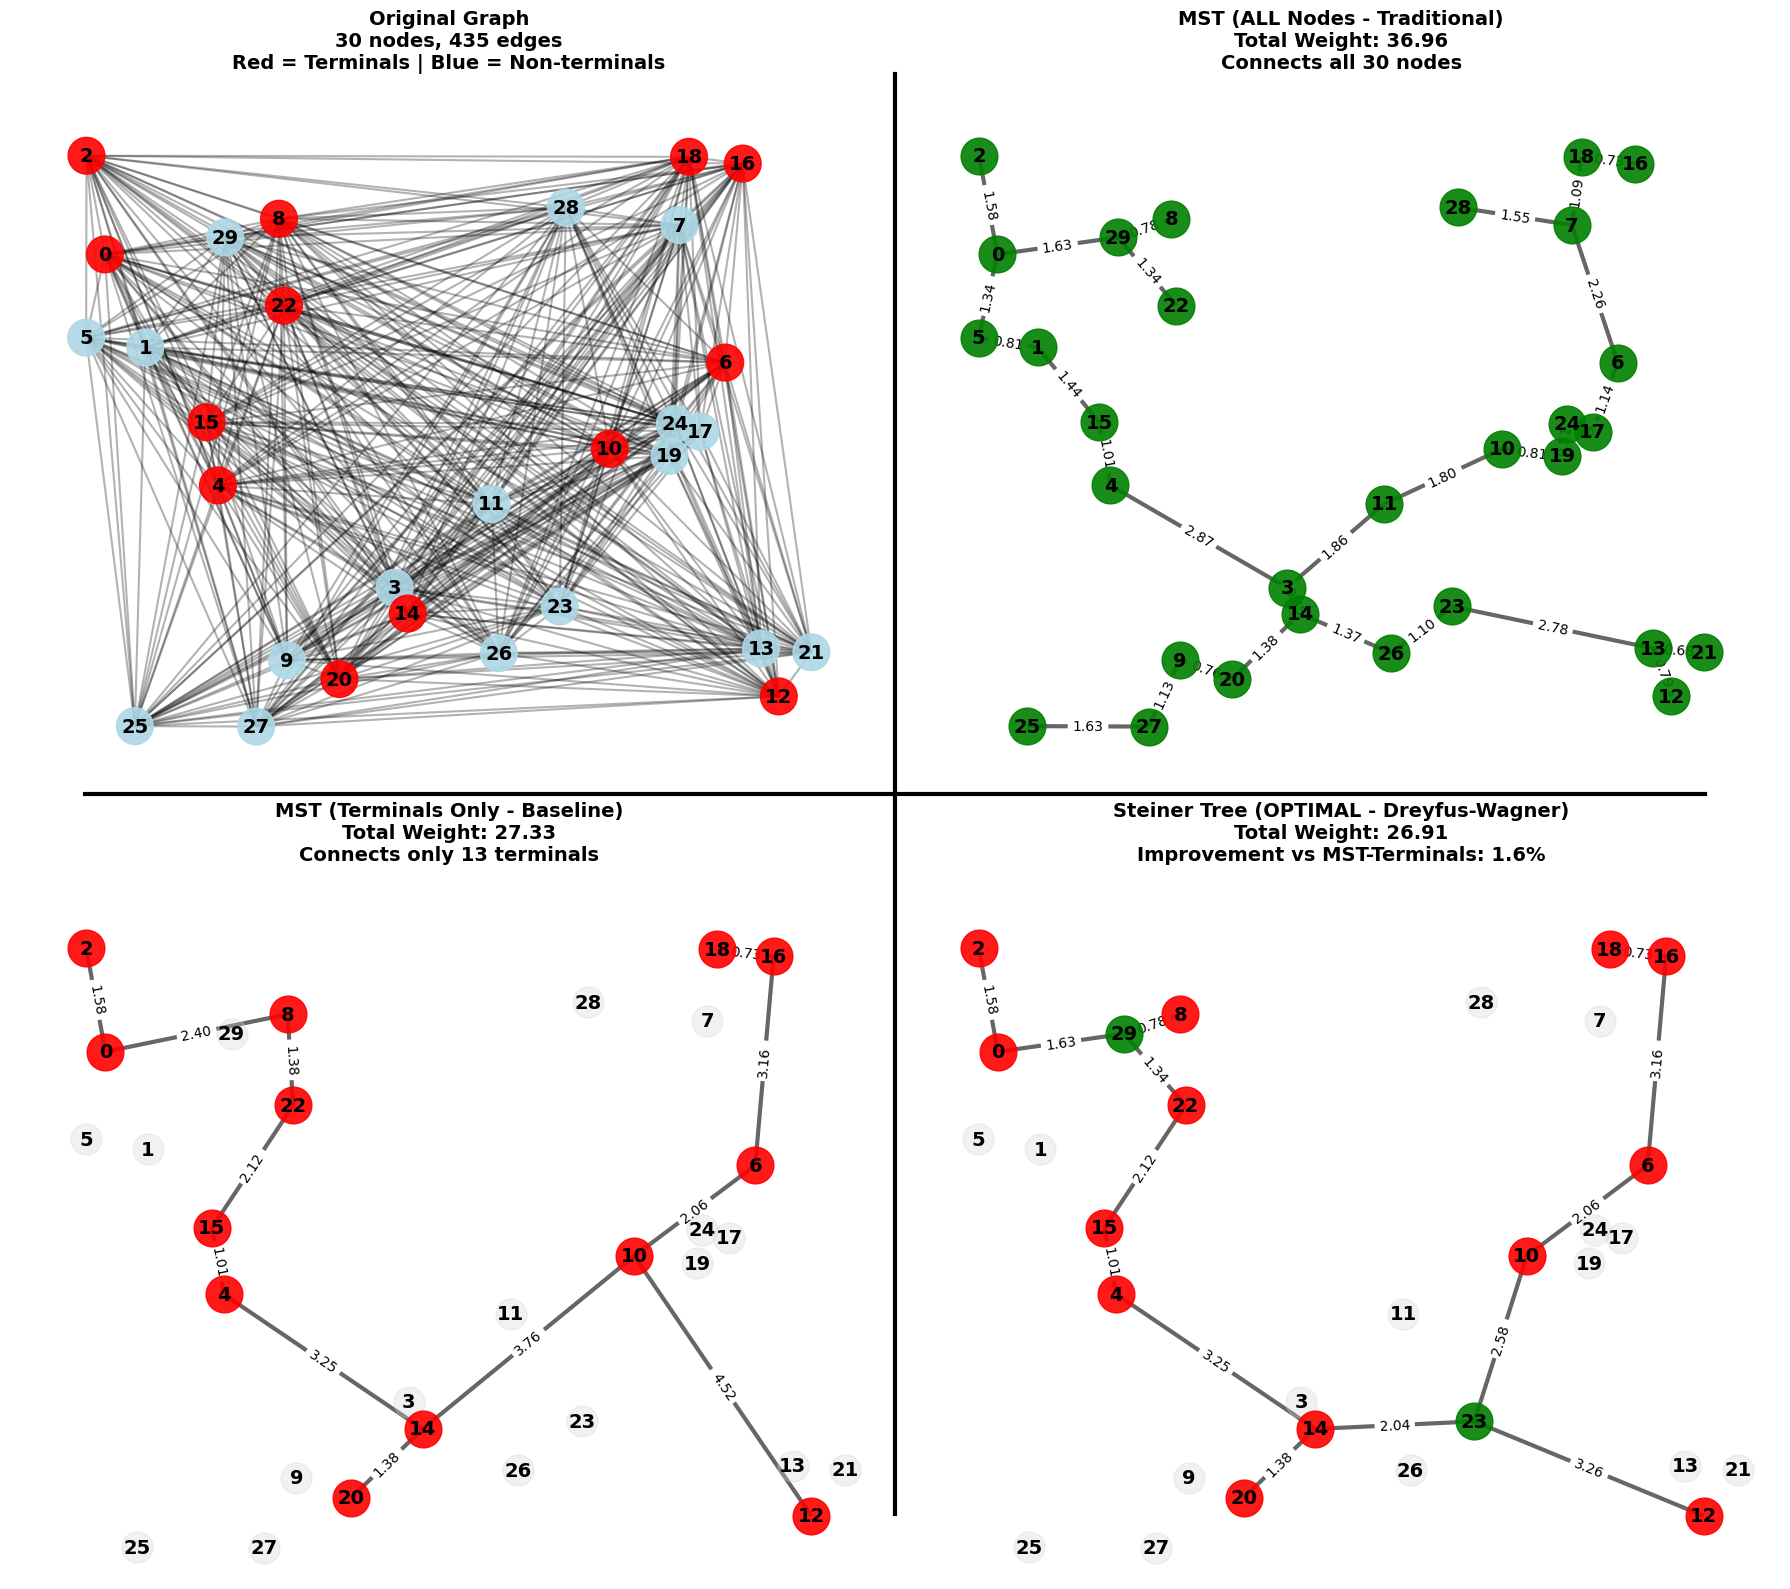

In [41]:
# Generate points
total_nodes = 30
points_exp = generate_random_points(n_nodes=total_nodes, seed=34)
G_exp = create_complete_graph(points_exp)
terminals_exp = [0, 2, 4, 6, 8, 10, 12, 14, 15, 16, 18, 20, 22]  # 13 terminales

print(f"Total nodes in graph: {len(points_exp)}")
print(f"Terminal nodes: {terminals_exp}")
print(f"Available Steiner nodes: {[i for i in range(total_nodes) if i not in terminals_exp]}")

# Traditional MST (all nodes)
mst_full_exp, mst_full_weight_exp = compute_mst(G_exp)
mst_terminals_exp, mst_terminals_weight_exp = compute_mst_terminals(G_exp, terminals_exp)

# Compute OPTIMAL Steiner Tree with Dreyfus-Wagner
steiner_exp, steiner_weight_exp, exec_time_exp = dreyfus_wagner(G_exp, terminals_exp)
steiner_nodes_used = [n for n in steiner_exp.nodes() if n not in terminals_exp]

# Plot comparison - 2x2 grid
plot_comparison(mst_full_exp, mst_terminals_exp, steiner_exp, mst_full_weight_exp, mst_terminals_weight_exp, steiner_weight_exp, terminals_exp, G_exp)

## Análisis de Complejidad: Tiempo vs Número de Terminales

Vamos a medir cómo crece el tiempo de ejecución a medida que aumentamos el número de nodos terminales.
Recordar: Complejidad teórica = O(3^n × n²) donde n = número de terminales.

In [48]:
def run_complexity_analysis(max_terminals=12, total_nodes=20, seed=100):
    """
    Analiza el tiempo de ejecución del algoritmo Dreyfus-Wagner
    para diferentes números de nodos terminales.
    
    Parameters:
    - max_terminals: Número máximo de terminales a probar (cuidado: crece exponencialmente!)
    - total_nodes: Número total de nodos en el grafo
    - seed: Semilla para reproducibilidad
    
    Returns: (terminal_counts, execution_times)
    """
    print(f"⚠️ Running complexity analysis up to {max_terminals} terminals...")
    print(f"⚠️ This may take several minutes due to exponential growth!\n")
    
    # Generate a single graph to use for all tests
    points = generate_random_points(n_nodes=total_nodes, seed=seed)
    G = create_complete_graph(points)
    
    terminal_counts = []
    execution_times = []
    
    # Test from 2 terminals up to max_terminals
    for n_terminals in range(2, max_terminals + 1):
        # Select first n_terminals nodes as terminals
        terminals = list(range(n_terminals))
        
        print(f"Testing with {n_terminals} terminals...", end=' ')
        
        # Run Dreyfus-Wagner and measure time
        _, _, exec_time = dreyfus_wagner(G, terminals)
        
        terminal_counts.append(n_terminals)
        execution_times.append(exec_time)
        
        print(f"Time: {exec_time:.4f} seconds")
    
    print("\n✓ Analysis completed!")
    return terminal_counts, execution_times


def plot_complexity_analysis(terminal_counts, execution_times):
    """
    Grafica el tiempo de ejecución vs número de terminales.
    """
    plt.figure(figsize=(12, 7))
    
    # Plot execution time
    plt.plot(terminal_counts, execution_times, 'o-', linewidth=2, markersize=8, color='blue', label='Tiempo real')
    
    # Add theoretical complexity line (3^n scaled to fit)
    # theoretical = [3**n / (3**terminal_counts[0]) * execution_times[0] for n in terminal_counts]
    # plt.plot(terminal_counts, theoretical, '--', linewidth=2, color='red', alpha=0.7, label='Complejidad teórica O(3^n)')
    
    plt.xlabel('Número de Nodos Terminales', fontsize=14, fontweight='bold')
    plt.ylabel('Tiempo de Ejecución (segundos)', fontsize=14, fontweight='bold')
    plt.title('Dreyfus-Wagner: Crecimiento Exponencial del Tiempo\nComplejidad O(3^n × n²)', 
              fontsize=16, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(fontsize=12)
    
    # Add values on points
    for x, y in zip(terminal_counts, execution_times):
        plt.annotate(f'{y:.3f}s', xy=(x, y), xytext=(5, 5), 
                    textcoords='offset points', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\n" + "="*60)
    print("RESUMEN DE TIEMPOS DE EJECUCIÓN")
    print("="*60)
    print(f"{'Terminales':<12} {'Tiempo (s)':<15} {'Factor vs anterior':<20}")
    print("-"*60)
    
    for i, (n, t) in enumerate(zip(terminal_counts, execution_times)):
        if i == 0:
            print(f"{n:<12} {t:<15.6f} {'(baseline)':<20}")
        else:
            factor = t / execution_times[i-1]
            print(f"{n:<12} {t:<15.6f} {f'{factor:.2f}x':<20}")
    
    print("="*60)
    print(f"\nTiempo total para {terminal_counts[-1]} terminales: {execution_times[-1]:.4f} segundos")
    print(f"Factor de crecimiento promedio: {(execution_times[-1]/execution_times[0])**(1/(len(execution_times)-1)):.2f}x por terminal")

print("Complexity analysis functions defined!")
print("⚠️ Use with caution: max_terminals > 12 puede tomar MUCHO tiempo!")

Complexity analysis functions defined!
⚠️ Use with caution: max_terminals > 12 puede tomar MUCHO tiempo!


⚠️ Running complexity analysis up to 14 terminals...
⚠️ This may take several minutes due to exponential growth!

Testing with 2 terminals... Time: 0.0080 seconds
Testing with 3 terminals... Time: 0.0095 seconds
Testing with 4 terminals... Time: 0.0095 seconds
Testing with 5 terminals... Time: 0.0120 seconds
Testing with 6 terminals... Time: 0.0180 seconds
Testing with 7 terminals... Time: 0.0309 seconds
Testing with 8 terminals... Time: 0.0606 seconds
Testing with 9 terminals... Time: 0.1532 seconds
Testing with 10 terminals... Time: 0.4063 seconds
Testing with 11 terminals... Time: 1.1422 seconds
Testing with 12 terminals... Time: 3.4398 seconds
Testing with 13 terminals... Time: 10.4878 seconds
Testing with 14 terminals... Time: 31.7072 seconds

✓ Analysis completed!


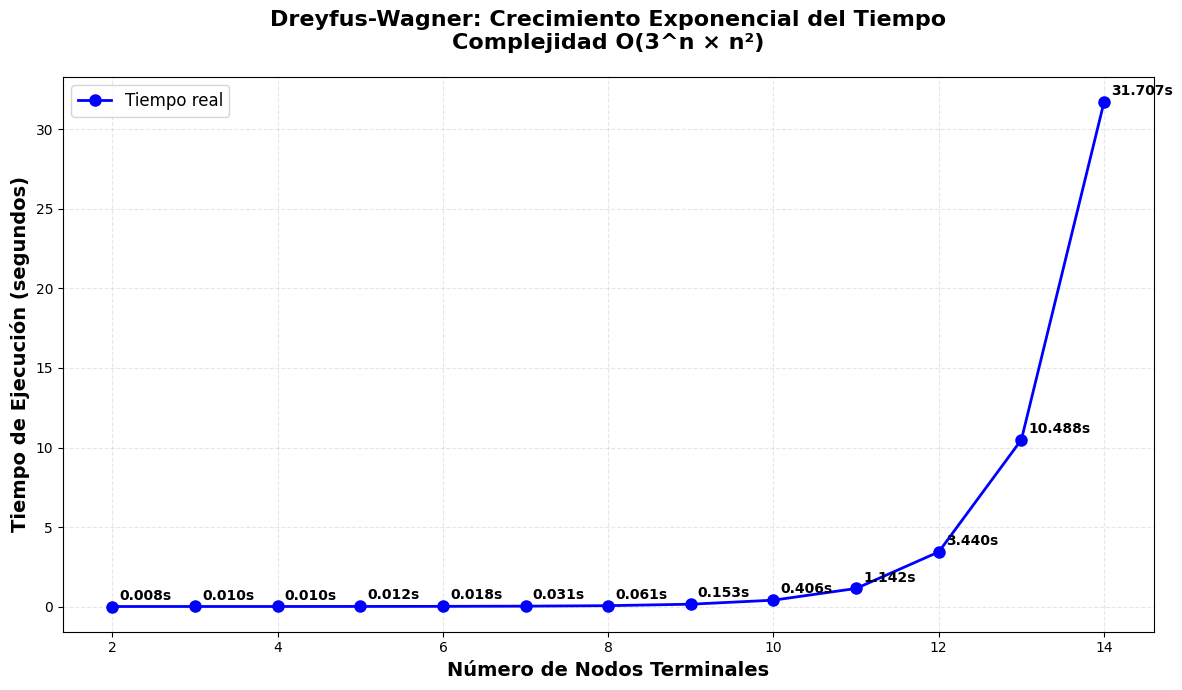


RESUMEN DE TIEMPOS DE EJECUCIÓN
Terminales   Tiempo (s)      Factor vs anterior  
------------------------------------------------------------
2            0.007999        (baseline)          
3            0.009500        1.19x               
4            0.009500        1.00x               
5            0.012000        1.26x               
6            0.018000        1.50x               
7            0.030900        1.72x               
8            0.060560        1.96x               
9            0.153204        2.53x               
10           0.406290        2.65x               
11           1.142204        2.81x               
12           3.439778        3.01x               
13           10.487791       3.05x               
14           31.707230       3.02x               

Tiempo total para 14 terminales: 31.7072 segundos
Factor de crecimiento promedio: 1.99x por terminal


In [50]:
# Ejecutar análisis de complejidad
# ADVERTENCIA: Cambiar max_terminals > 12 puede tomar MUCHO tiempo (crecimiento exponencial)
terminal_counts, execution_times = run_complexity_analysis(max_terminals=14, total_nodes=40, seed=42)

# Graficar resultados
plot_complexity_analysis(terminal_counts, execution_times)